In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model

In [2]:
df = pd.read_csv("final-data.csv")
all_cols = df.columns

In [3]:
univariate_data = ["Date", "BONAP:NO2"]

In [4]:
# load only the target variable
df = pd.read_csv("final-data.csv")[univariate_data]

In [5]:
# fill the missing values
df["BONAP:NO2"] = df["BONAP:NO2"].fillna(df["BONAP:NO2"].mean())

In [6]:
df.isna().sum()

Date         0
BONAP:NO2    0
dtype: int64

In [7]:
# we set the date as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [8]:
df

BONAP:NO2
Date                          
2022-01-01 01:00:00       39.8
2022-01-01 04:00:00       29.3
2022-01-01 07:00:00       25.9
2022-01-01 10:00:00       19.5
2022-01-01 13:00:00       26.3
...                        ...
2023-01-01 10:00:00       16.8
2023-01-01 13:00:00       16.8
2023-01-01 16:00:00       16.8
2023-01-01 19:00:00       16.8
2023-01-01 22:00:00       16.8

[2928 rows x 1 columns]

<Axes: xlabel='Date'>

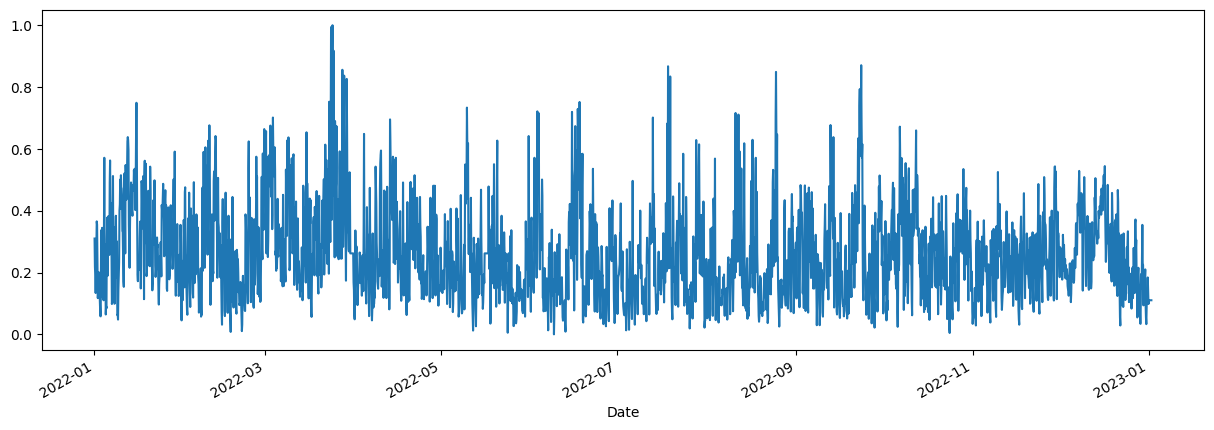

In [9]:
from sklearn.preprocessing import minmax_scale

# on visualise nos données
scaled_price_block_df = pd.DataFrame(minmax_scale(df),
                                     columns=df.columns,
                                     index=df.index)
scaled_price_block_df["BONAP:NO2"].plot(figsize=(15, 5))

In [10]:
# nos parametres de prédiction
HORIZON = 1
WINDOW_SIZE = 10

df_copy =  df.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  df_copy[f"BONAP:NO2+{i+1}"] = df_copy["BONAP:NO2"].shift(periods=i+1)
df_copy.dropna()


BONAP:NO2  BONAP:NO2+1  BONAP:NO2+2  BONAP:NO2+3  \
Date                                                                    
2022-01-02 07:00:00       21.3         17.6         32.3         45.0   
2022-01-02 10:00:00       20.6         21.3         17.6         32.3   
2022-01-02 13:00:00       27.2         20.6         21.3         17.6   
2022-01-02 16:00:00       23.1         27.2         20.6         21.3   
2022-01-02 19:00:00       18.5         23.1         27.2         20.6   
...                        ...          ...          ...          ...   
2023-01-01 10:00:00       16.8         16.8         16.8         16.8   
2023-01-01 13:00:00       16.8         16.8         16.8         16.8   
2023-01-01 16:00:00       16.8         16.8         16.8         16.8   
2023-01-01 19:00:00       16.8         16.8         16.8         16.8   
2023-01-01 22:00:00       16.8         16.8         16.8         16.8   

                     BONAP:NO2+4  BONAP:NO2+5  BONAP:NO2+6  BONAP:NO2+7  \
Date                                                                      
2022-01-02 07:00:00         46.2         36.8         26.3         19.5   
2022-01-02 10:00:00         45.0         46.2         36.8         26.3   
2022-01-02 13:00:00         32.3         45.0         46.2         36.8   
2022-01-02 16:00:00         17.6         32.3         45.0         46.2   
2022-01-02 19:00:00         21.3         17.6         32.3         45.0   
...                          ...          ...          ...          ...   
2023-01-01 10:00:00         15.4         20.4         25.3         19.7   
2023-01-01 13:00:00         16.8         15.4         20.4         25.3   
2023-01-01 16:00:00         16.8         16.8         15.4         20.4   
2023-01-01 19:00:00         16.8         16.8         16.8         15.4   
2023-01-01 22:00:00         16.8         16.8         16.8         16.8   

                     BONAP:NO2+8  BONAP:NO2+9  BONAP:NO2+10  
Date                                                         
2022-01-02 07:00:00         25.9         29.3          39.8  
2022-01-02 10:00:00         19.5         25.9          29.3  
2022-01-02 13:00:00         26.3         19.5          25.9  
2022-01-02 16:00:00         36.8         26.3          19.5  
2022-01-02 19:00:00         46.2         36.8          26.3  
...                          ...          ...           ...  
2023-01-01 10:00:00         16.3         14.8           7.9  
2023-01-01 13:00:00         19.7         16.3          14.8  
2023-01-01 16:00:00         25.3         19.7          16.3  
2023-01-01 19:00:00         20.4         25.3          19.7  
2023-01-01 22:00:00         15.4         20.4          25.3  

[2918 rows x 11 columns]

In [11]:
x = df_copy.dropna().drop("BONAP:NO2", axis=1)
y = df_copy.dropna()["BONAP:NO2"]

In [12]:
# we split our data
split_size = int(len(x) * 0.8)
X_train, y_train = x[:split_size], y[:split_size]
X_test, y_test = x[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2334, 2334, 584, 584)

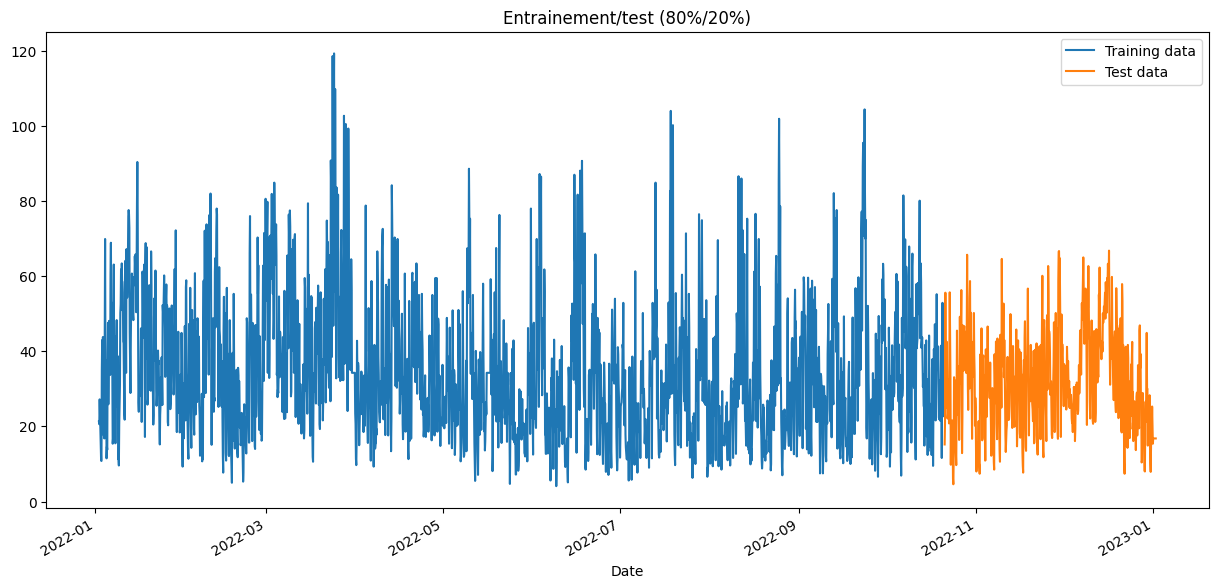

In [13]:
plt.figure(figsize=(15, 7))
y_train.plot(label = "Training data")
y_test.plot(label = "Test data")
plt.title("Entrainement/test (80%/20%)")
plt.legend()

In [14]:
import os

# ModelCheckpoint callback to our dir
def create_model_checkpoint(model_name, save_path="Univariate models"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), 
                                            verbose=0, 
                                            save_best_only=True, 
                                            save_freq=5)

In [15]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
tf.random.set_seed(42)
X_train_reshaped, X_test_reshaped = tf.expand_dims(X_train, 2), tf.expand_dims(X_test, 2) 

In [16]:
def rss_loss(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_true - y_pred))

# LSTM
LSTM_model = Sequential()
LSTM_model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(LSTM(128, activation='relu', return_sequences=False))
LSTM_model.add(Dropout(0.1))
LSTM_model.add(Dense(1)) # output Dim 1
opt = Adam(learning_rate=0.000001)
LSTM_model.compile(loss = rss_loss, optimizer=opt)


# GRU
GRU_model = Sequential()
GRU_model.add(GRU(128, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True))
GRU_model.add(Dropout(0.2))
GRU_model.add(GRU(64, activation='relu', return_sequences=False))
GRU_model.add(Dropout(0.2))
GRU_model.add(Dense(1)) # output
opt = Adam(learning_rate=0.000001)
GRU_model.compile(loss = rss_loss, optimizer=opt) 

# LSTM + GRU
both_model = Sequential()
both_model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True))
both_model.add(Dropout(0.2))
both_model.add(GRU(64, activation='relu', return_sequences=False))
both_model.add(Dropout(0.2))
both_model.add(Dense(1)) # output 
both_opt = Adam(learning_rate=0.000001)
both_model.compile(loss= rss_loss, optimizer=opt)


# CNN
Conv_model = Sequential()
Conv_model.add(Conv1D(filters=128, kernel_size=3, padding="causal", activation="relu", input_shape=(X_train.shape[1], 1)))
Conv_model.add(MaxPooling1D(pool_size=2))
Conv_model.add(Conv1D(filters=64, kernel_size=3, padding="causal", activation="relu"))
Conv_model.add(MaxPooling1D(pool_size=2))
Conv_model.add(Flatten())
Conv_model.add(Dense(64, activation="relu"))
Conv_model.add(Dropout(0.2))
Conv_model.add(Dense(1))
Conv_opt = Adam(learning_rate=0.000001)

Conv_model.compile(loss=rss_loss, optimizer=Conv_opt)

You can skip this cell as you can load the pretrained models after

In [17]:
print("Let's train the Lstm network")
lstm_history = LSTM_model.fit(X_train_reshaped, y_train,
          epochs=2000,
          batch_size=80,
          verbose=1, 
          validation_data=(X_test_reshaped, y_test),
          callbacks=[EarlyStopping(monitor='val_loss', patience=15)])


print("*"*100)
print("Let's train the Gru network")

GrU_history = GRU_model.fit(X_train_reshaped, y_train,
          epochs=2000,
          batch_size=80,
          verbose=1, 
          validation_data=(X_test_reshaped, y_test),
          callbacks=[EarlyStopping(monitor='val_loss', patience=15), create_model_checkpoint(model_name="GRU")])


print("*"*100)
print("Let's train Lstm+Gru network")

both_history = both_model.fit(X_train_reshaped, y_train,
          epochs=2000,
          batch_size=80,
          verbose=1, 
          validation_data=(X_test_reshaped, y_test),
          callbacks=[EarlyStopping(monitor='val_loss', patience=15), create_model_checkpoint(model_name="GRU+LSTM")])

print("Let's train CNN network")
Conv_history = Conv_model.fit(X_train_reshaped, y_train,
            batch_size=80, 
            epochs=2000,
            verbose=1,
            validation_data=(X_test_reshaped, y_test),
            callbacks=[EarlyStopping(monitor='val_loss', patience=15), create_model_checkpoint(model_name="CNN")])

Let's train the Lstm network
Epoch 1/2000
30/30 [==============================] - 2s 28ms/step - loss: 120497.2031 - val_loss: 95345.2109
Epoch 2/2000
30/30 [==============================] - 1s 22ms/step - loss: 120424.5938 - val_loss: 94871.2812
Epoch 3/2000
30/30 [==============================] - 1s 21ms/step - loss: 119509.5078 - val_loss: 94402.6406
Epoch 4/2000
30/30 [==============================] - 1s 21ms/step - loss: 119257.5938 - val_loss: 93941.6641
Epoch 5/2000
30/30 [==============================] - 1s 21ms/step - loss: 118357.5938 - val_loss: 93480.9688
Epoch 6/2000
30/30 [==============================] - 1s 24ms/step - loss: 117661.5078 - val_loss: 93021.1484
Epoch 7/2000
30/30 [==============================] - 1s 23ms/step - loss: 117227.8047 - val_loss: 92568.9141
Epoch 8/2000
30/30 [==============================] - 1s 22ms/step - loss: 117236.0547 - val_loss: 92116.4297
Epoch 9/2000
30/30 [==============================] - 1s 31ms/step - loss: 116352.7812 - va

INFO:tensorflow:Assets written to: Univariate models/CNN\assets


INFO:tensorflow:Assets written to: Univariate models/CNN\assets


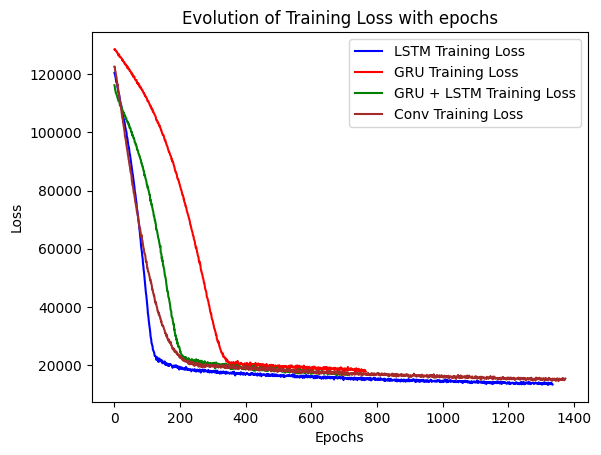

In [18]:
plt.plot(lstm_history.history["loss"], label='LSTM Training Loss', color='blue')
plt.plot(GrU_history.history["loss"], label='GRU Training Loss', color='red')
plt.plot(both_history.history["loss"], label='GRU + LSTM Training Loss', color='green')
plt.plot(Conv_history.history["loss"], label='Conv Training Loss', color='brown')
#plt.plot(Conv_history.history["loss"], label='Conv Training Loss', color='brown')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution of Training Loss with epochs')
plt.legend()
plt.show()

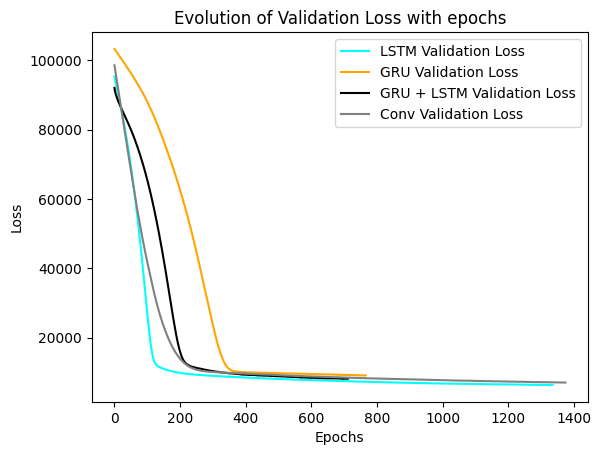

In [19]:
plt.plot(lstm_history.history["val_loss"], label='LSTM Validation Loss', color='cyan')
plt.plot(GrU_history.history["val_loss"], label='GRU Validation Loss', color='orange')
plt.plot(both_history.history["val_loss"], label='GRU + LSTM Validation Loss', color='black')
plt.plot(Conv_history.history["val_loss"], label='Conv Validation Loss', color='grey')
#plt.plot(Conv_history.history["val_loss"], label='Conv Validation Loss', color='grey')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution of Validation Loss with epochs')
plt.legend()
plt.show()

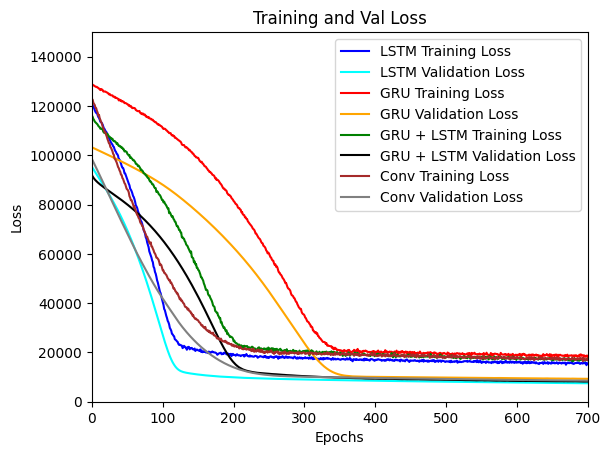

In [20]:
plt.plot(lstm_history.history["loss"], label='LSTM Training Loss', color='blue')
plt.plot(lstm_history.history["val_loss"], label='LSTM Validation Loss', color='cyan')
plt.plot(GrU_history.history["loss"], label='GRU Training Loss', color='red')
plt.plot(GrU_history.history["val_loss"], label='GRU Validation Loss', color='orange')
plt.plot(both_history.history["loss"], label='GRU + LSTM Training Loss', color='green')
plt.plot(both_history.history["val_loss"], label='GRU + LSTM Validation Loss', color='black')
plt.plot(Conv_history.history["loss"], label='Conv Training Loss', color='brown')
plt.plot(Conv_history.history["val_loss"], label='Conv Validation Loss', color='grey')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Val Loss')
plt.legend()
plt.xlim(0, 700)
plt.ylim(0, 150000)

plt.show()

Notre fonction d'évaluation

In [21]:
from keras.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# notre fonction d'évaluation

def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = mean_absolute_percentage_error(y_true, y_pred)
  
  mae = tf.reduce_mean(mae)
  mse = tf.reduce_mean(mse)
  rmse = tf.reduce_mean(rmse)
  mape = tf.reduce_mean(mape)

  return {"mse":mse.numpy()} # On va juste s'interesser en mse
        #{"mae": mae.numpy(),
        #"rmse": rmse.numpy(),
        #"mape": mape.numpy(),
        #"mase": mase.numpy()}

Let's now load our pretrained models

19/19 [==============================] - 1s 8ms/step


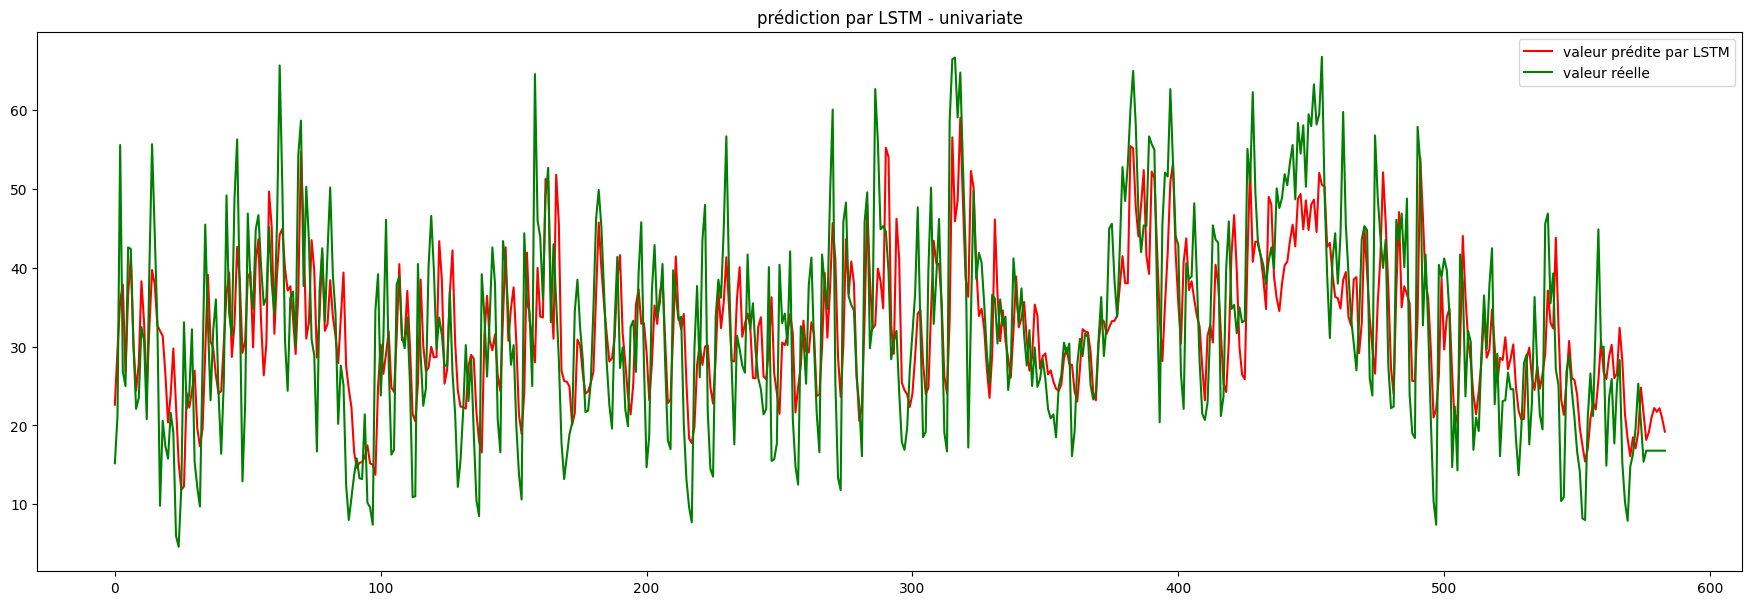

In [22]:
LSTM_model = load_model("Univariate models\LSTM", custom_objects={'rss_loss': rss_loss}) 
LSTM_preds = LSTM_model.predict(X_test_reshaped)
LSTM_results = evaluate_preds(y_true=y_test,
                                 y_pred=LSTM_preds)
plt.figure(figsize=(22, 7))
plt.plot(LSTM_preds, color="red", label="valeur prédite par LSTM")
plt.plot(y_test.values, color = "green",label="valeur réelle")
plt.title("prédiction par LSTM - univariate")
plt.legend()

19/19 [==============================] - 1s 6ms/step


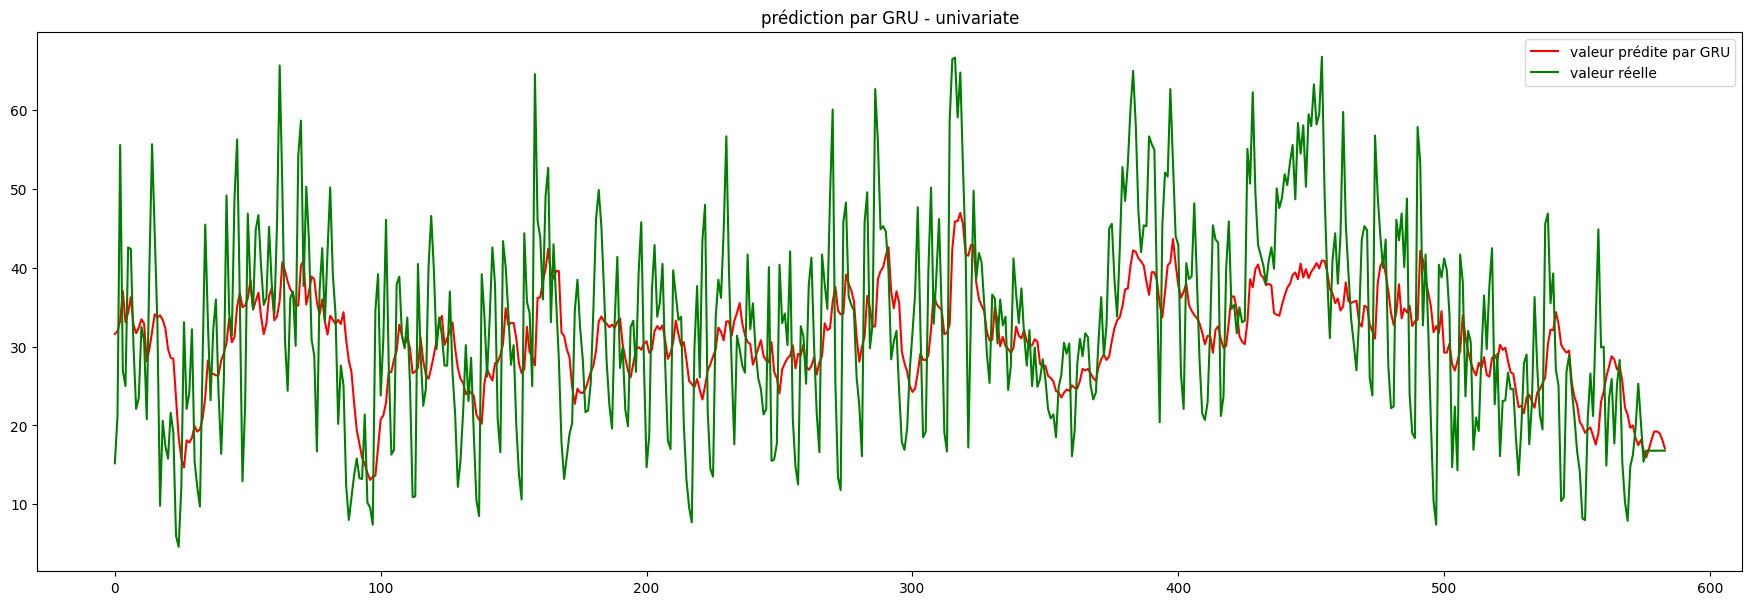

In [23]:
# load our GRU model
GRU_model = load_model("Univariate models\GRU", custom_objects={'rss_loss': rss_loss}) 
GRU_preds = GRU_model.predict(X_test_reshaped)
GRU_results = evaluate_preds(y_true=y_test,
                                 y_pred=GRU_preds)
plt.figure(figsize=(22, 7))
plt.plot(GRU_preds, color="red", label="valeur prédite par GRU")
plt.plot(y_test.values, color = "green",label="valeur réelle")
plt.title("prédiction par GRU - univariate")
plt.legend()

19/19 [==============================] - 1s 8ms/step


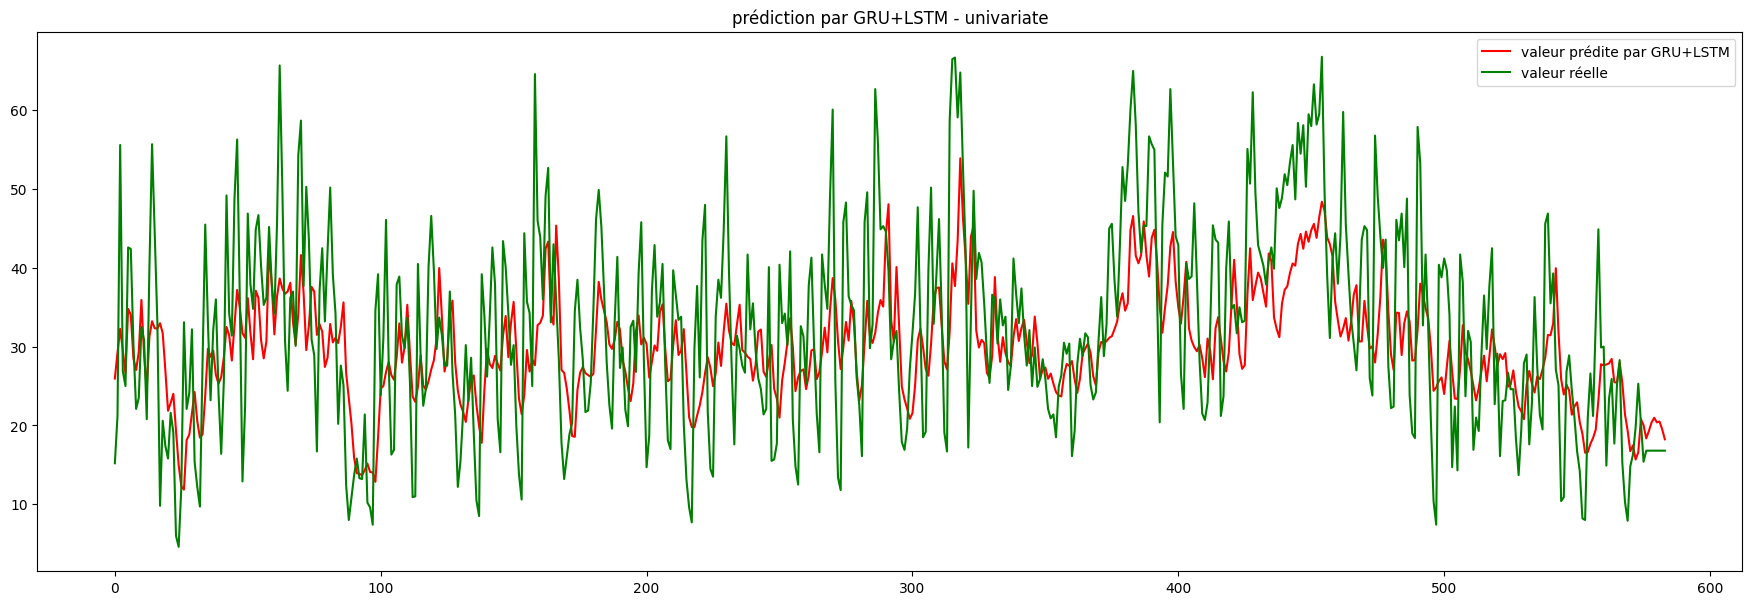

In [24]:
# combine GRU with LSTM
both_model = load_model("Univariate models\GRU+LSTM", custom_objects={'rss_loss': rss_loss}) 
both_preds = both_model.predict(X_test_reshaped)
both_results = evaluate_preds(y_true=y_test,
                                 y_pred=both_preds)
plt.figure(figsize=(22, 7))
plt.plot(both_preds, color="red", label="valeur prédite par GRU+LSTM")
plt.plot(y_test.values, color = "green",label="valeur réelle")
plt.title("prédiction par GRU+LSTM - univariate")
plt.legend()

19/19 [==============================] - 0s 3ms/step


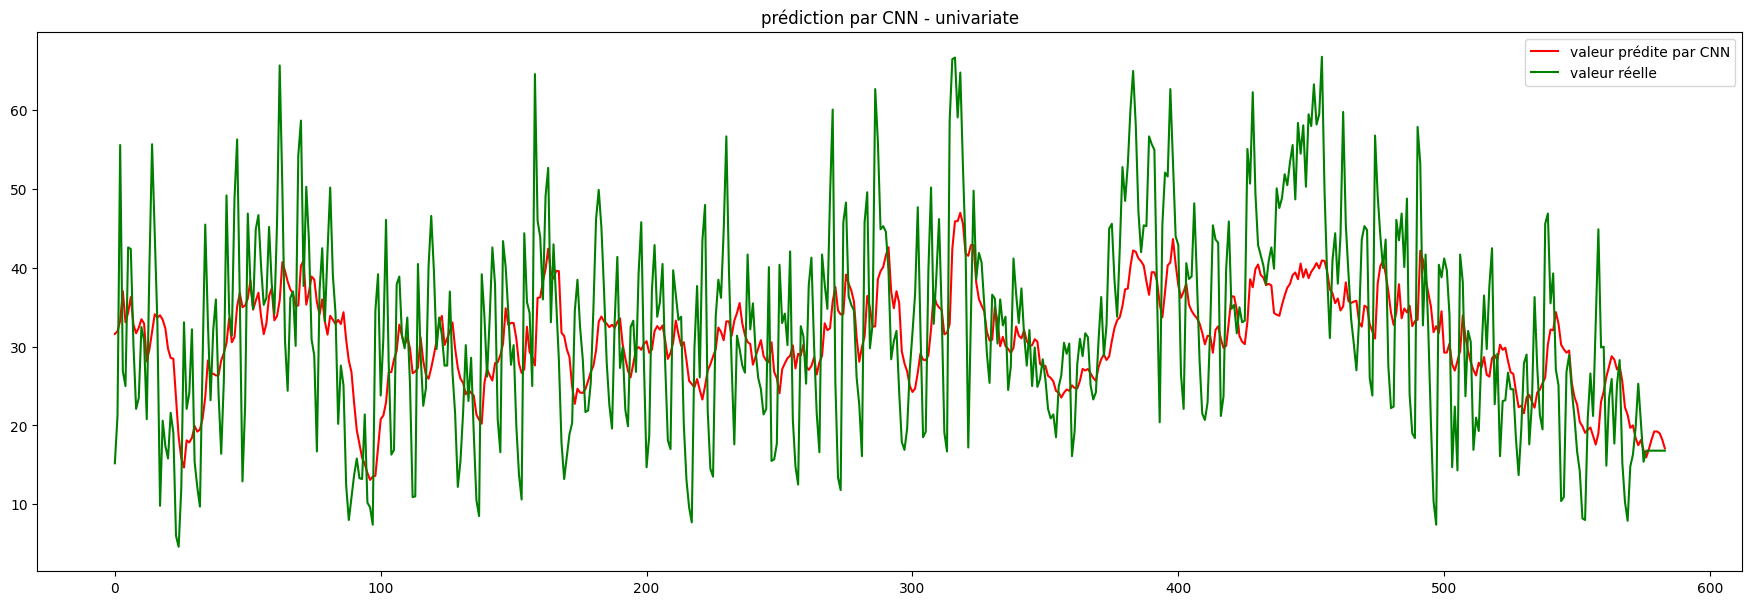

In [25]:
# load our CNN model
CNN_model = load_model("Univariate models\CNN", custom_objects={'rss_loss': rss_loss}) 
CNN_preds = CNN_model.predict(X_test_reshaped)
CNN_results = evaluate_preds(y_true=y_test,
                                 y_pred=CNN_preds)
plt.figure(figsize=(22, 7))
plt.plot(GRU_preds, color="red", label="valeur prédite par CNN")
plt.plot(y_test.values, color = "green",label="valeur réelle")
plt.title("prédiction par CNN - univariate")
plt.legend()

Let's compare the RSS LOSS

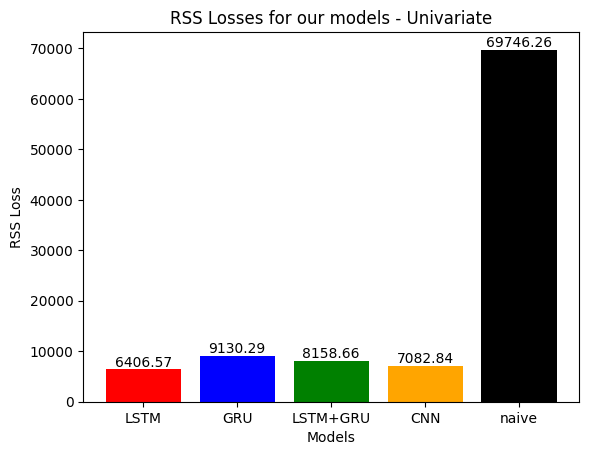

In [27]:
histories = [lstm_history, GrU_history, both_history, Conv_history]
naive_forecast = y_test[:-1]
naive_ = tf.reduce_sum(tf.square(naive_forecast.values - y_test[1:].values))
rss_loss = [min(item.history["val_loss"]) for item in histories] + [naive_.numpy()]

model_names = ['LSTM', 'GRU', 'LSTM+GRU', 'CNN', 'naive']

# Bar plot
plt.bar(model_names, rss_loss, color=["red", "blue", "green", "orange","black"])
plt.xlabel('Models')
plt.ylabel('RSS Loss')
plt.title('RSS Losses for our models - Univariate')

for i, loss in enumerate(rss_loss):
    plt.text(i, loss + 0.1, f'{loss:.2f}', ha='center', va='bottom')

plt.show()


Let's visualize the mse loss

19/19 [==============================] - 0s 722us/step


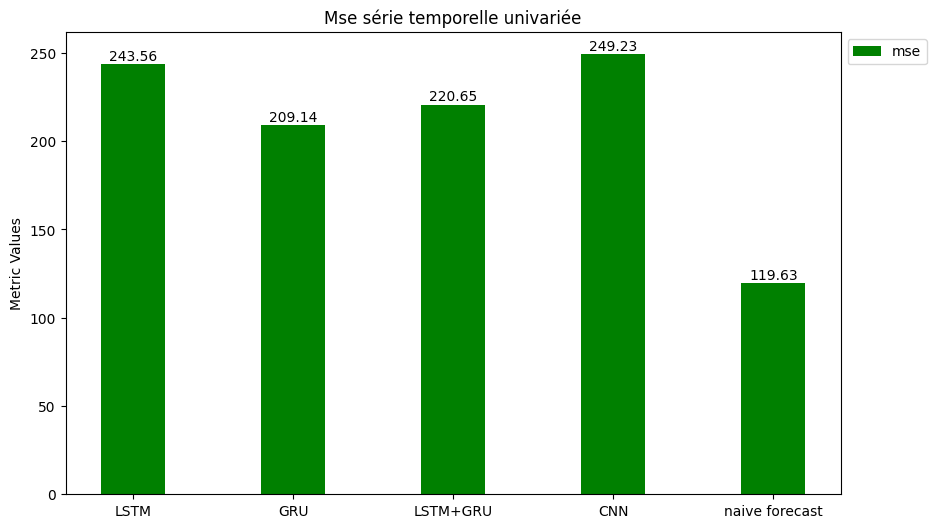

In [28]:

LSTM_preds = LSTM_model.predict(X_test_reshaped)
LSTM_results = evaluate_preds(y_true=y_test,
                                 y_pred=LSTM_preds)
GRU_preds = GRU_model.predict(X_test_reshaped)
GRU_results = evaluate_preds(y_true=y_test,
                                 y_pred=GRU_preds)
both_preds = both_model.predict(X_test_reshaped)
both_results = evaluate_preds(y_true=y_test,
                                 y_pred=both_preds)
Conv_preds = Conv_model.predict(X_test_reshaped)
Conv_results = evaluate_preds(y_true=y_test,
                                 y_pred=Conv_preds)

# naive approache :
naive_forecast = y_test[:-1]
naive_results = evaluate_preds(y_true=y_test[1:],
                                 y_pred=naive_forecast.values)

results= [LSTM_results, GRU_results, both_results, Conv_results, naive_results]

metrics = ['mse']
models = ['LSTM', 'GRU', 'LSTM+GRU', 'CNN', "naive forecast"]

x = np.arange(len(models))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(metrics):
    offset = width * i
    rects = ax.bar(x + offset, [results[j][metric] for j in range(len(results))], width, label=metric, color = "green")
    
    # Add labels manually (horizontally)
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.5, f'{height:.2f}', ha='center', va='bottom')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Metric Values')
ax.set_title('Mse série temporelle univariée')
ax.set_xticks(x + width * (len(metrics) - 1) / 2)
ax.set_xticklabels(models)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust the y-axis limits as needed

plt.show()
